*Threaded implementation of BGP.*

### Extracted Story
Several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. Each general observes the enemy and communicates his observation to the others. Each general then combines all the reported observations into a single plan of action (i.e., “attack” or “retreat”), for example, by using a majority vote. Communicating only by messengers, the generals must agree upon a common, and reasonable battle plan, however, one or more of them may be traitors who will try to confuse the others. All loyal generals must carry out the same plan, whereas the traitors may do anything they wish.

### Extracted Story (verbatim)
We imagine that several divisions of the Byzantine army are camped outside an enemy city, each division commanded by its own general. The generals can communicate with one another only by messenger. After observing the enemy, they must decide upon a common plan of action. However, some of the generals may be traitors, trying to prevent the loyal generals from reaching agreement.
...
All loyal generals decide upon the same plan of action... but the traitors may do anything they wish.
...
They loyal generals should not only reach agreement, but should agree upon a reasonable plan.

*Everything below this point is based on the verbatim version of the story.*

### User Stories
* As a GENERAL I want to...
  * make observations on an enemy city to decide upon a plan of action.
  * be able to communicate with other genrals to share our observations.
* As a LOYAL GENERAL I want to...
  * decide upon a reasonable plan of action so that my division does what is best.
  * decide upon the same plan of action as all other loyal generals so order within the army is maintained.
* As a DISLOYAL GENERAL I want to...
  * make false or contradicting observations to prevent the loyal generals from reaching agreement.
* As a MESSENGER I want to...
  * deliver messages between generals/divisons so they can reach upon some agreement.


### Design Decisions

* Traitors always return RETREAT.
* The code is modelled to be thematically accurate, thus;
    * Each general has "his own" messenger.
    * When a general "speaks", he dispatches jobs to his messenger who delivers them to the other generals.
    * When a general "listens", he adds what he heard to his list of observations and dispatches his messenger to propagate the message.
    * The commander kick-starts the cycle.
* The recursive algorithm is replaced by threads executing jobs placed on a queue.
    * This makes it difficult to know when we're finished - a timeout of 2 seconds is used here.
* There is no sophisticated integrity/authenticity checking of any kind, nor does this code verify the claims made in the BGP paper. It is merely a proof of concept for demonstration purposes.


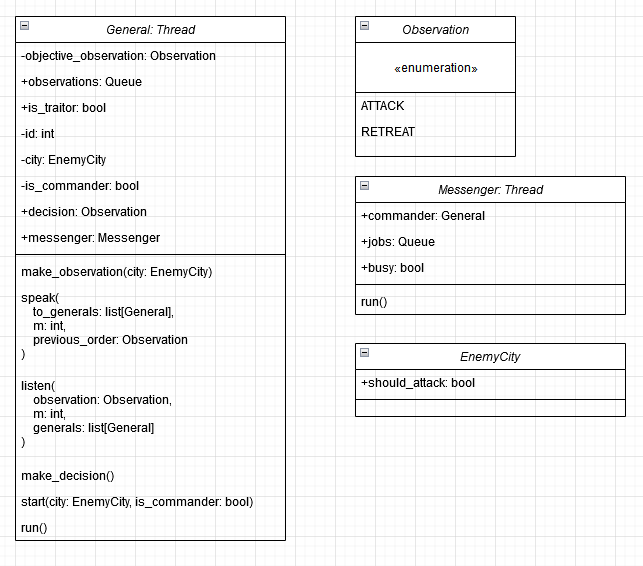


### Example Execution

Below is a diagram of an example execution where C represents the commander, L the loyal general, and T1 and T2 two traitorous generals. The messengers have been omitted for clarity. Moreover, since the code is threaded, it can be assumed that the order of communications (represented by the edges on the graph) is, effectively, simultaneous.

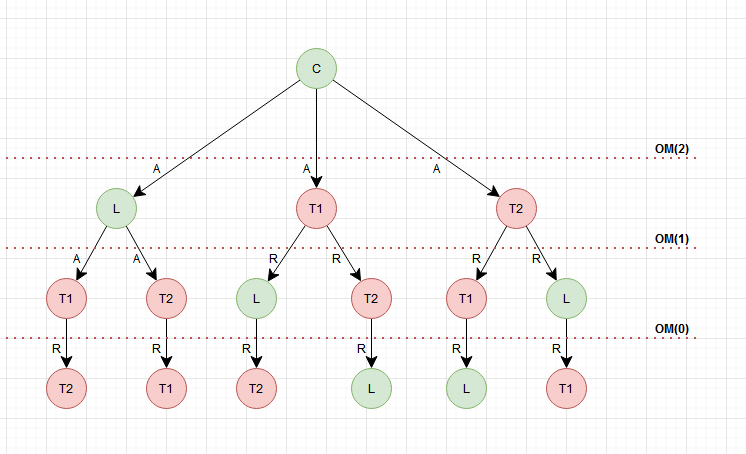

```
Running test (4, 2)
--------------------

[PLAN=Observation.RETREAT ATTACK=5 RETREAT=10]

<General 9 [l]>: [], 0
<General 10 [l]>: [(<Observation.RETREAT: 2>, 4), (<Observation.ATTACK: 1>, 1)], 5
<General 11 [t]>: [(<Observation.RETREAT: 2>, 3), (<Observation.ATTACK: 1>, 2)], 5
<General 12 [t]>: [(<Observation.RETREAT: 2>, 3), (<Observation.ATTACK: 1>, 2)], 5
```

In [1]:
import time
import random
import logging
from threading import Thread
from queue import Queue, Empty
from enum import Enum, auto
from collections import Counter

In [2]:
logging.basicConfig(level=100, force=True)

In [3]:
class Observation(Enum):
    '''
    Represents an observation that a general has made on a particular city.
    '''
    ATTACK = auto()
    RETREAT = auto()

In [4]:
class EnemyCity:
    def __init__(self, should_attack):
        # A city is modelled to be "objectively" either attackable or not
        self.should_attack = should_attack

In [5]:
class Messenger(Thread):
    def __init__(self, commander, *a, **kw):
        super().__init__(*a, **kw)

        self.commander = commander
        self.jobs = Queue()
        self.busy = False

    def run(self):
        self.busy = True
        
        while True:
            try:
                generals, m, g, o = self.jobs.get(timeout=2)
                g.listen(o, m, generals)
            except Empty:
                break
        
        self.busy = False

In [6]:
class General(Thread):
    '''
    Represents a General who is either loyal or a traitor.
    '''
    # Used for easier representation
    next_id = 0
    _generals = []

    def __init__(self, is_traitor=False):
        super().__init__()
        
        self._objective_observation = None
        self.observations = Queue()
        self.is_traitor = is_traitor

        self._id = General.next_id
        General.next_id += 1
        
        self._city = None
        self._is_commander = False
        
        self.decision = None
        self.messenger = Messenger(self)
        
        General._generals.append(self)
    
    def make_observation(self, city: EnemyCity):
        self._objective_observation = (Observation.RETREAT, Observation.ATTACK)[city.should_attack]
    
    def speak(self, to_generals, m, previous_order=None):
        o = Observation.RETREAT
        
        if not self.is_traitor:
            if previous_order is not None:
                o = previous_order
            else:
                o = self._objective_observation

        for g in to_generals:
            self.messenger.jobs.put(
                (to_generals, m, g, o)
            )
    
    def listen(self, observation, m, generals):
        self.observations.put(observation)
        
        if m > 0:
            _generals = [x for x in generals if x is not self]
            self.speak(_generals, m-1, observation)
    
    def make_decision(self):
        return Counter(self.observations.queue).most_common()
    
    def start(self, city, is_commander=False):
        self._city = city
        self._is_commander = is_commander
        super().start()
    
    def run(self):
        self.make_observation(self._city)
        
        if self._is_commander:
            self.speak(
                [x for x in General._generals if x is not self],
                len([x for x in General._generals if x.is_traitor])
            )
        
        self.messenger.start()
        
        while self.messenger.busy:
            time.sleep(1)
        
        self.messenger.join()
        self.decision = self.make_decision()
    
    def __repr__(self) -> str:
        return f'<General {self._id} [{"t" if self.is_traitor else "l"}]>'

In [7]:
def main(total_generals, num_traitors=-1, should_attack=None):
    '''
    Run the main simulation between a number of generals.

    :param total_generals: The TOTAL number of generals
    :param num_traitors: The number of traitors.
        Can be expressed either as...
            int >= 0                 for an absolute size
            float >= 0.0 and <= 1.0  for a percentage of `total_generals`
            int < 0                  for random distribution
    :param should_attack: Should the city be objectively attackable or not.
        (default: random)
    :return: The PoA agreed to by the loyal generals.
        ("retreat", "attack" or None)
    '''
    n_traitors = 0
    
    if isinstance(num_traitors, int):
        if num_traitors >= 0:
            n_traitors = num_traitors
        else:
            n_traitors = int(total_generals * random.random())
    elif isinstance(num_traitors, float) and 0 <= num_traitors <= 1:
        n_traitors = int(total_generals * num_traitors)
    
    generals = [General(False) for _ in range(total_generals - n_traitors)] + \
               [General(True) for _ in range(n_traitors)]
    
    if should_attack is not None:
        city = EnemyCity(should_attack)
    else:
        city = EnemyCity(random.choice([True, False]))
    
    logging.info(
        f'Running with {total_generals} total generals of which'
        f' {n_traitors} are traitorous. EnemyCity.should_attack == {city.should_attack}\n'
    )
    
    for i, g in enumerate(generals):
        g.start(city, i == 0)
    
    for g in generals:
        g.join()
    
    # Each general comes up with a plan of action
    loyal_poa, agreed_plan = set(), None
    
    for g in generals:
        if not g.observations.queue:
            continue
            
        decision = g.decision[0][0]
        
        if not g.is_traitor:
            loyal_poa.add(decision)
    
    if len(loyal_poa) != 1:
        logging.info('Loyal Generals cannot agree on a plan of action!!!\n')
    else:
        agreed_plan = loyal_poa.pop()
        logging.info(f'Loyal Generals have agreed on: {agreed_plan}\n')
    
    total_a, total_r = 0, 0

    for g in generals:
        a, r = 0, 0
        
        for msg in g.observations.queue:
            if msg is Observation.ATTACK:
                a += 1
            else:
                r += 1
        
        total_a += a
        total_r += r

        logging.debug(
            f'{"[!] " if g.is_traitor else ""}'
            f'General {g._id} has made the objective observation of {g._objective_observation.name}'
            f' and reported ATTTACK {a} times and RETREAT {r} times'
        )
    
    return generals, agreed_plan, total_a, total_r

In [8]:
def test_runner(test_cases, test_runs):
    """
    A simple test runner for this implementation of the BGP.
    
    :param test_cases: a list of tuples specifying what
        tests should be run in the format [(num_generals, num_traitors), ...]
    :param test_runs: the number of times that each test should be run
    """
    # [(num_generals, num_traitors), ...]
    ret = []
    
    for test in test_cases:
        print(f'\n\nRunning test {test}\n{"-"*20}')

        for _ in range(test_runs):
            generals, plan, a, r = main(*test, True)
            ret.append((generals, plan, a, r))
            
            print(f'\n[PLAN={plan} ATTACK={a} RETREAT={r}]\n')

            for general in generals:
                observations = [0, 0]  # attack, retreat

#                 for observation in general.last_observations:
#                     if observation is Observation.ATTACK:
#                         observations[0] += 1
#                     else:
#                         observations[1] += 1
                
#                 print(f'{general}: attack={observations[0]} retreat={observations[1]}')
                print(f'{general}: {general.decision}, {len(general.observations.queue)}')
    
    return ret

In [9]:
if __name__ == '__main__':
    # m = 10  # 10 traitors
    
    # # The loyal generals should all agree to the same reasonable plan
    # main((3 * m) + 1, m)
    
    # # Here, the loyal generals *should* fail to 
    # # reach agreement or agree to an "unreasonable" plan.
    # # (This doesn't actually happen...)
    # main((3 * m), m)  # Note the missing `+1`
    
    # main(15, 10)

    tests = [
        (9, 3),
        (4, 2)
    ]

    x = test_runner(tests, 1)



Running test (9, 3)
--------------------

[PLAN=Observation.RETREAT ATTACK=463 RETREAT=1617]

<General 0 [l]>: [], 0
<General 1 [l]>: [(<Observation.RETREAT: 2>, 219), (<Observation.ATTACK: 1>, 41)], 260
<General 2 [l]>: [(<Observation.RETREAT: 2>, 219), (<Observation.ATTACK: 1>, 41)], 260
<General 3 [l]>: [(<Observation.RETREAT: 2>, 219), (<Observation.ATTACK: 1>, 41)], 260
<General 4 [l]>: [(<Observation.RETREAT: 2>, 219), (<Observation.ATTACK: 1>, 41)], 260
<General 5 [l]>: [(<Observation.RETREAT: 2>, 219), (<Observation.ATTACK: 1>, 41)], 260
<General 6 [t]>: [(<Observation.RETREAT: 2>, 174), (<Observation.ATTACK: 1>, 86)], 260
<General 7 [t]>: [(<Observation.RETREAT: 2>, 174), (<Observation.ATTACK: 1>, 86)], 260
<General 8 [t]>: [(<Observation.RETREAT: 2>, 174), (<Observation.ATTACK: 1>, 86)], 260


Running test (4, 2)
--------------------

[PLAN=Observation.RETREAT ATTACK=5 RETREAT=10]

<General 9 [l]>: [], 0
<General 10 [l]>: [(<Observation.RETREAT: 2>, 4), (<Observation.ATTACK